#### 1. Proportion of revenue levels per tag
#### 2. Mean, standard deviation, median dollar value per tag
#### 3. Transaction frequency per tag

To do:
1. Number of unique merchants/consumers per tag - Andrew
2. Age distribution by tag (add visualization) - Andrew
3. Consumer income distribution by tag (add visualization) - Andrew
4. Take rate * Dollar_Value - Andrew
5. Unique SA2 per merchant - Patrick
6. Analyze buying power (transaction frequency and monetary value) of SA2, possibly ranking weights to merchants by SA2 - Patrick
6.1 Add SA2 (Income, Age and Buying Power) Geospatial Visualization - Nadya
7. Finalize features to use -> find correlation between features

### Analysis by Tag

In [3]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/09/08 12:31:24 WARN Utils: Your hostname, LAPTOP-URHBN55Q resolves to a loopback address: 127.0.1.1; using 10.13.207.233 instead (on interface wifi0)
22/09/08 12:31:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/08 12:31:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")

In [5]:
consumer.show(1, vertical=True)

-RECORD 0---------------------------
 name        | Yolanda Williams     
 address     | 413 Haney Gardens... 
 state       | WA                   
 postcode    | 6935                 
 gender      | Female               
 consumer_id | 1195503              
only showing top 1 row



In [6]:
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")

In [7]:
details.show(10, vertical=True)

-RECORD 0--------------
 user_id     | 1       
 consumer_id | 1195503 
-RECORD 1--------------
 user_id     | 2       
 consumer_id | 179208  
-RECORD 2--------------
 user_id     | 3       
 consumer_id | 1194530 
-RECORD 3--------------
 user_id     | 4       
 consumer_id | 154128  
-RECORD 4--------------
 user_id     | 5       
 consumer_id | 712975  
-RECORD 5--------------
 user_id     | 6       
 consumer_id | 407340  
-RECORD 6--------------
 user_id     | 7       
 consumer_id | 511685  
-RECORD 7--------------
 user_id     | 8       
 consumer_id | 448088  
-RECORD 8--------------
 user_id     | 9       
 consumer_id | 650435  
-RECORD 9--------------
 user_id     | 10      
 consumer_id | 1058499 
only showing top 10 rows



In [8]:
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [9]:
merchants.show(3, vertical=True)

-RECORD 0----------------------------
 name         | Felis Limited        
 tags         | ((furniture, home... 
 merchant_abn | 10023283211          
-RECORD 1----------------------------
 name         | Arcu Ac Orci Corp... 
 tags         | ([cable, satellit... 
 merchant_abn | 10142254217          
-RECORD 2----------------------------
 name         | Nunc Sed Company     
 tags         | ([jewelry, watch,... 
 merchant_abn | 10165489824          
only showing top 3 rows



In [10]:
transactions = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
transactions2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")

In [11]:
transactions.show(1, vertical=True)

-RECORD 0------------------------------
 user_id        | 18478                
 merchant_abn   | 62191208634          
 dollar_value   | 63.255848959735246   
 order_id       | 949a63c8-29f7-4ab... 
 order_datetime | 2021-08-20           
only showing top 1 row



In [12]:
# Join consumers with their respective details
consumer_user = consumer.join(details, on="consumer_id")

In [13]:
# Join consumers with their respective transactions
consumer_transactions = consumer_user.join(transactions, on="user_id")

In [14]:
consumer_transactions.show(5, vertical=True)

-RECORD 0------------------------------
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 merchant_abn   | 33064796871          
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
-RECORD 1------------------------------
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 merchant_abn   | 68435002949          
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 
 order_datetime | 2021-08-20           
-RECORD 2------------------------------


In [15]:
# Join transactions with the respective merchants
consumer_merchants = consumer_transactions.join(merchants, on="merchant_abn")

In [16]:
consumer_merchants.show(5, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 33064796871          
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 373.0873675184212    
 order_id       | fe188788-b89f-4dd... 
 order_datetime | 2021-08-20           
 name           | Curabitur Massa C... 
 tags           | ((computer progra... 
-RECORD 1------------------------------
 merchant_abn   | 68435002949          
 user_id        | 7                    
 consumer_id    | 511685               
 name           | Andrea Jones         
 address        | 122 Brandon Cliff    
 state          | QLD                  
 postcode       | 4606                 
 gender         | Female               
 dollar_value   | 232.5364986739752    
 order_id       | b4a89891-a113-45e... 


In [17]:
# Explore product tags for purchase frequency
consumer_merchants.groupby("tags").count().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+-----+
|tags                                                                                                             |count|
+-----------------------------------------------------------------------------------------------------------------+-----+
|((lawn and garden suppLy outlets, including nurseries), (a), (take rate: 6.02))                                  |148  |
|[[watch, clock, and jewelry repair shops], [a], [take rate: 5.93]]                                               |2502 |
|[[florists supplies, nursery stock, and flowers], [a], [take rate: 5.58]]                                        |163  |
|([artist supply and craft shops], [a], [take rate: 6.04])                                                        |452  |
|((tent and awning shops), (b), (take rate: 3.43))                                                                |336  |
|([tent and awning shops

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

In [19]:
consumer_merchants = consumer_merchants.withColumn("tags", normalize_tags(F.col("tags")))

In [20]:
consumer_merchants.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)



In [21]:
consumer_merchants = consumer_merchants.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))

In [22]:
consumer_merchants = consumer_merchants.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))

In [23]:
consumer_merchants = consumer_merchants.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))

In [24]:
consumer_merchants = consumer_merchants.withColumn("take_rate", F.col("take_rate").astype(FloatType()))

In [25]:
@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [26]:
consumer_merchants = consumer_merchants.withColumn("categories", clean_string(F.col("categories")))

In [27]:
category_take_rates = consumer_merchants.select(["categories", "revenue_level", "take_rate"]).toPandas()

In [28]:
import pandas as pd
pd.set_option('display.max_rows', None)

/home/aaa/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='revenue_level', ylabel='take_rate'>

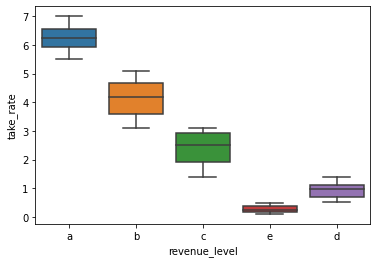

In [29]:
import seaborn as sns
sns.boxplot(category_take_rates["revenue_level"], category_take_rates["take_rate"])

Revenue levels can be categorized by its take rate

In [30]:
category_take_rates.groupby(["categories", "revenue_level"]).size().agg(
  {'count': lambda x: x, 'percent':lambda x: x / x.groupby(level=0).sum() * 100}
  ).unstack(level=0).reset_index()

,categories,revenue_level,count,percent
0,"antique shops - sales, repairs, and restoratio...",a,7645.0,16.595394
1,"antique shops - sales, repairs, and restoratio...",b,19240.0,41.765255
2,"antique shops - sales, repairs, and restoratio...",c,17204.0,37.345605
3,"antique shops - sales, repairs, and restoratio...",d,1693.0,3.675082
4,"antique shops - sales, repairs, and restoratio...",e,285.0,0.618664
5,art dealers and galleries,a,1506.0,27.547101
6,art dealers and galleries,b,2966.0,54.252789
7,art dealers and galleries,c,858.0,15.694165
8,art dealers and galleries,d,14.0,0.256082
9,art dealers and galleries,e,123.0,2.249863


We can see which categories provide the better amount in revenue for our BNPL company

In [49]:
category_prices = consumer_merchants.select(["categories", "dollar_value"]).toPandas()
category_prices = category_prices[category_prices["dollar_value"] >= 35]

In [54]:
category_prices.groupby("categories").agg(["mean", "std", "median", "count"])

dollar_value               \
                                                           mean          std   
categories                                                                     
antique shops - sales, repairs, and restoration...   415.874877  2163.273003   
art dealers and galleries                           2099.335962  2111.937410   
artist supply and craft shops                        405.470712   411.261485   
bicycle shops - sales and service                    366.387825   564.638738   
books, periodicals, and newspapers                   282.032289   234.776615   
cable, satellite, and other pay television and ...   101.379583    55.667565   
computer programming , data processing, and int...   215.166858   167.591602   
computers, computer peripheral equipment, and s...   239.073501   256.847946   
digital goods: books, movies, music                   90.078967    48.588737   
equipment, tool, furniture, and appliance rent ...  1545.815378  1754.023212   
florists supplies, nursery stock, and flowers        180.512450   188.576520   
furniture, home furnishings and equipment shops...   256.050383   481.178133   
gift, card, novelty, and souvenir shops               93.028825    49.868315   
health and beauty spas                               333.776936   284.472463   
hobby, toy and game shops                            324.852800   597.561414   
jewelry, watch, clock, and silverware shops         9321.586684  7819.944464   
lawn and garden supply outlets, including nurse...   338.878750   466.634778   
motor vehicle supplies and new parts                 382.474508   668.294115   
music shops - musical instruments, pianos, and ...   333.472316   411.981677   
opticians, optical goods, and eyeglasses             149.253331   156.646367   
shoe shops                                           233.595505   210.575382   
stationery, office supplies and printing and wr...   479.067683   370.367969   
telecom                                             1879.810051  1856.580205   
tent and awning shops                                205.852980   437.422654   
watch, clock, and jewelry repair shops               107.830046    73.423218   

                                                                         
                                                         median   count  
categories                                                               
antique shops - sales, repairs, and restoration...   146.495486   39686  
art dealers and galleries                           1602.006586    5396  
artist supply and craft shops                        270.365642   75060  
bicycle shops - sales and service                    136.896812   48643  
books, periodicals, and newspapers                   213.331331   89493  
cable, satellite, and other pay television and ...    86.945606  179197  
computer programming , data processing, and int...   177.624723  117429  
computers, computer peripheral equipment, and s...   119.827280  124496  
digital goods: books, movies, music                   77.423045  213650  
equipment, tool, furniture, and appliance rent ...   967.146150    7918  
florists supplies, nursery stock, and flowers         93.927455  135312  
furniture, home furnishings and equipment shops...   154.869913  111496  
gift, card, novelty, and souvenir shops               81.208270  281531  
health and beauty spas                               247.901434   55778  
hobby, toy and game shops                            112.796425   47509  
jewelry, watch, clock, and silverware shops         7557.976652    1248  
lawn and garden supply outlets, including nurse...   212.106126   82444  
motor vehicle supplies and new parts                 250.180616   74411  
music shops - musical instruments, pianos, and ...   132.980136   64670  
opticians, optical goods, and eyeglasses              87.869069  118424  
shoe shops                                           161.153509   93982  
stationery, office supplies and pr

/home/aaa/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='categories', ylabel='dollar_value'>

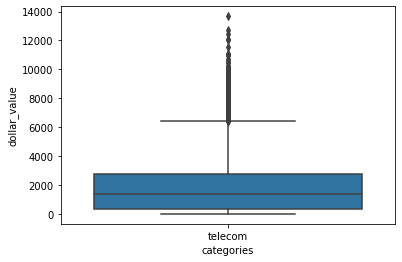

In [51]:
sns.boxplot(category_prices[category_prices["categories"] == "telecom"].loc[:,"categories"], \
    category_prices[category_prices["categories"] == "telecom"].loc[:,"dollar_value"])

In [53]:
category_prices.groupby("categories").count()

,dollar_value
categories,
"antique shops - sales, repairs, and restoration services",39686
art dealers and galleries,5396
artist supply and craft shops,75060
bicycle shops - sales and service,48643
"books, periodicals, and newspapers",89493
"cable, satellite, and other pay television and radio services",179197
"computer programming , data processing, and integrated systems design services",117429
"computers, computer peripheral equipment, and software",124496
"digital goods: books, movies, music",213650
